<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [122]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Input
import pandas as pd
import numpy as np
from librosa.core import resample, load
from librosa.util import fix_length
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
)
from matplotlib import pyplot as plt

In [39]:
data = pd.read_csv('clean.csv')
classes_cols = [
    'class_Djembe',
    'class_Timbales',
    'class_Clave',
    'class_Agogo',
    'class_Bongo',
    'class_Tambourin',
    'class_Shaken',
    'class_Conga',
    'class_Cowbell',
    'class_Clap',
    'class_Cymbal',
    'class_Tom',
    'class_Hat',
    'class_Kick',
    'class_Snare'
]
nb_classes = len(classes_cols)
data = data[data[classes_cols].sum(axis=1) == 1]

In [40]:
data.shape

(7998, 45)

In [41]:
data.head()

,path,filename,dir_1,class_Hat,subclass_Hat_Open,subclass_Hat_Close,class_Bongo,class_Cymbal,subclass_Cymbal_Crash,subclass_Cymbal_Ride,...,subclass_Shaken_Maracas,class_Cajon,class_clave,dir_2,subclass_Snare_Off,subclass_Snare_On,subclass_Snare_Side,subclass_Snare_Flam,subclass_Snare_Brush,subclass_Cymbal_Trash
0,./Samples/200-drum-machines/Yamaha RX-11/MaxV ...,MaxV - RX11 OPHAT2.wav,Yamaha RX-11,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0
1,./Samples/200-drum-machines/Yamaha RX-11/MaxV ...,MaxV - RX11 BD3.wav,Yamaha RX-11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0
2,./Samples/200-drum-machines/Yamaha RX-11/MaxV ...,MaxV - RX11 BD2.wav,Yamaha RX-11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0
3,./Samples/200-drum-machines/Yamaha RX-11/MaxV ...,MaxV - RX11 CLHAT2.wav,Yamaha RX-11,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0
4,./Samples/200-drum-machines/Yamaha RX-11/MaxV ...,MaxV - RX11 RIDE.wav,Yamaha RX-11,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0


In [42]:
data = data.loc[data['path'] != './Samples/200-drum-machines/Roland JV 1080/MaxV - Guiro.wav']

In [43]:
vggish = hub.load('https://tfhub.dev/google/vggish/1')
yamnet = hub.load('https://tfhub.dev/google/yamnet/1')

In [44]:
SR=16000
classes = data[classes_cols]
files = data['path']
vgg_embeddings = []
yam_embeddings = []
for path in files:
    sound, _ = load(path, sr=SR)
    sound = fix_length(sound, 1*SR)
    vgg_embeddings.append(vggish(sound))
    _, yam_emb, _ = yamnet(sound)
    yam_embeddings.append(yam_emb)

vgg_embeddings = np.stack(vgg_embeddings)
yam_embeddings = np.stack(yam_embeddings)

In [45]:
vgg_embeddings.shape, yam_embeddings.shape

((7998, 1, 128), (7998, 2, 1024))

In [46]:
vgg_embeddings = vgg_embeddings.reshape(-1, 128)
yam_embeddings = yam_embeddings.reshape(-1, 2*1024)

array([12, 13, 13, ..., 11, 14, 11])

In [113]:
# x_train, x_valid, y_train, y_valid = train_test_split(sounds, classes, test_size=0.3, stratify=classes)
x_vgg_train, x_vgg_valid, x_yam_train, x_yam_valid, y_train, y_valid = train_test_split(vgg_embeddings, yam_embeddings, classes, test_size=0.3, stratify=classes)

In [114]:
x_vgg_train.shape

(5598, 128)

In [197]:
inputs = Input(shape=(128))
x = Dense(100, activation='relu')(inputs)
x = Dropout(0.3)(x)
x = Dense(50, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(nb_classes, activation='softmax')(x)

model = Model(inputs, outputs)
model.summary()

Model: "functional_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        [(None, 128)]             0         
_________________________________________________________________
dense_31 (Dense)             (None, 100)               12900     
_________________________________________________________________
dropout_8 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_32 (Dense)             (None, 50)                5050      
_________________________________________________________________
dropout_9 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_33 (Dense)             (None, 15)                765       
Total params: 18,715
Trainable params: 18,715
Non-trainable params: 0
_________________________________________________

In [198]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [199]:
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=classes_cols,
    y=y_train.idxmax(axis=1))
history = model.fit(x_vgg_train, y_train, epochs=100, validation_data=(x_vgg_valid, y_valid))

Epoch 1/100
175/175 [==============================] - 0s 2ms/step - loss: 1.7492 - accuracy: 0.3837 - val_loss: 1.1846 - val_accuracy: 0.6442
Epoch 2/100
175/175 [==============================] - 0s 1ms/step - loss: 1.1717 - accuracy: 0.6031 - val_loss: 0.9231 - val_accuracy: 0.7121
Epoch 3/100
175/175 [==============================] - 0s 1ms/step - loss: 0.9915 - accuracy: 0.6758 - val_loss: 0.8107 - val_accuracy: 0.7433
Epoch 4/100
175/175 [==============================] - 0s 1ms/step - loss: 0.9076 - accuracy: 0.6954 - val_loss: 0.7601 - val_accuracy: 0.7442
Epoch 5/100
175/175 [==============================] - 0s 1ms/step - loss: 0.8588 - accuracy: 0.7106 - val_loss: 0.7389 - val_accuracy: 0.7496
Epoch 6/100
175/175 [==============================] - 0s 1ms/step - loss: 0.8189 - accuracy: 0.7281 - val_loss: 0.7049 - val_accuracy: 0.7667
Epoch 7/100
175/175 [==============================] - 0s 1ms/step - loss: 0.7885 - accuracy: 0.7362 - val_loss: 0.6974 - val_accuracy: 0.7696

Epoch 58/100
175/175 [==============================] - 0s 1ms/step - loss: 0.4191 - accuracy: 0.8600 - val_loss: 0.4941 - val_accuracy: 0.8487
Epoch 59/100
175/175 [==============================] - 0s 1ms/step - loss: 0.4193 - accuracy: 0.8574 - val_loss: 0.4973 - val_accuracy: 0.8462
Epoch 60/100
175/175 [==============================] - 0s 1ms/step - loss: 0.4154 - accuracy: 0.8608 - val_loss: 0.4963 - val_accuracy: 0.8500
Epoch 61/100
175/175 [==============================] - 0s 1ms/step - loss: 0.4155 - accuracy: 0.8587 - val_loss: 0.4973 - val_accuracy: 0.8521
Epoch 62/100
175/175 [==============================] - 0s 1ms/step - loss: 0.4149 - accuracy: 0.8635 - val_loss: 0.4947 - val_accuracy: 0.8533
Epoch 63/100
175/175 [==============================] - 0s 1ms/step - loss: 0.3986 - accuracy: 0.8637 - val_loss: 0.4931 - val_accuracy: 0.8471
Epoch 64/100
175/175 [==============================] - 0s 1ms/step - loss: 0.4065 - accuracy: 0.8641 - val_loss: 0.4971 - val_accuracy:

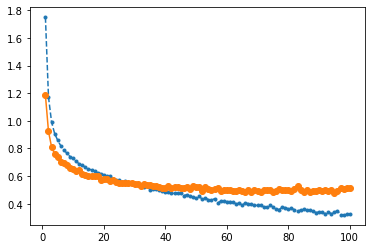

In [200]:
loss = history.history['loss']
epochs = range(1, len(loss) + 1)
val_loss = history.history['val_loss']
plt.plot(epochs, loss, '.--', label='Training loss')
plt.plot(epochs, val_loss, 'o-', label='Validation loss')
plt.show()

In [201]:
y_pred = model.predict(x_vgg_valid)
y_pred = np.argmax(y_pred,axis=1).astype(int)
y_valid_index = np.argmax(y_valid.values,axis=1).astype(int)

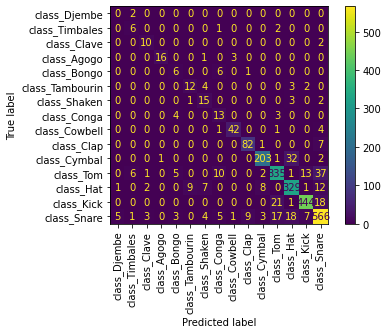

In [202]:
conf_matrix = ConfusionMatrixDisplay(
    confusion_matrix(y_pred, y_valid_index),
    display_labels=classes_cols,
)
conf_matrix.plot(xticks_rotation=90);

In [203]:
print(classification_report(y_pred, y_valid_index, target_names=classes_cols))

                 precision    recall  f1-score   support

   class_Djembe       0.00      0.00      0.00         2
 class_Timbales       0.40      0.67      0.50         9
    class_Clave       0.62      0.83      0.71        12
    class_Agogo       0.94      0.80      0.86        20
    class_Bongo       0.33      0.46      0.39        13
class_Tambourin       0.55      0.57      0.56        21
   class_Shaken       0.48      0.71      0.58        21
    class_Conga       0.36      0.65      0.46        20
  class_Cowbell       0.91      0.88      0.89        48
     class_Clap       0.89      0.91      0.90        90
   class_Cymbal       0.94      0.85      0.89       239
      class_Tom       0.88      0.82      0.85       410
      class_Hat       0.85      0.89      0.87       369
     class_Kick       0.95      0.92      0.93       484
    class_Snare       0.87      0.88      0.88       642

       accuracy                           0.87      2400
      macro avg       0.67   

In [204]:
inputs = Input(shape=(2048))
x = Dropout(0.5)(inputs)
x = Dense(100, activation='relu')(x)
x = Dropout(0.3)(inputs)
x = Dense(50, activation='relu')(x)
x = Dropout(0.3)(inputs)
outputs = Dense(nb_classes, activation='softmax')(x)

model2 = Model(inputs, outputs)
model2.summary()

Model: "functional_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        [(None, 2048)]            0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_36 (Dense)             (None, 15)                30735     
Total params: 30,735
Trainable params: 30,735
Non-trainable params: 0
_________________________________________________________________


In [205]:
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [206]:
history = model2.fit(x_yam_train, y_train, epochs=100, validation_data=(x_yam_valid, y_valid))

Epoch 1/100
175/175 [==============================] - 0s 2ms/step - loss: 2.1084 - accuracy: 0.3783 - val_loss: 1.4879 - val_accuracy: 0.5733
Epoch 2/100
175/175 [==============================] - 0s 2ms/step - loss: 1.5281 - accuracy: 0.4971 - val_loss: 1.2495 - val_accuracy: 0.5983
Epoch 3/100
175/175 [==============================] - 0s 2ms/step - loss: 1.3043 - accuracy: 0.5545 - val_loss: 1.0561 - val_accuracy: 0.6283
Epoch 4/100
175/175 [==============================] - 0s 2ms/step - loss: 1.1893 - accuracy: 0.5931 - val_loss: 1.0889 - val_accuracy: 0.6308
Epoch 5/100
175/175 [==============================] - 0s 2ms/step - loss: 1.0875 - accuracy: 0.6193 - val_loss: 0.9423 - val_accuracy: 0.6733
Epoch 6/100
175/175 [==============================] - 0s 2ms/step - loss: 1.0752 - accuracy: 0.6267 - val_loss: 1.0206 - val_accuracy: 0.6233
Epoch 7/100
175/175 [==============================] - 0s 2ms/step - loss: 0.9869 - accuracy: 0.6543 - val_loss: 0.9058 - val_accuracy: 0.7117

Epoch 58/100
175/175 [==============================] - 0s 2ms/step - loss: 0.6829 - accuracy: 0.7546 - val_loss: 0.7435 - val_accuracy: 0.7754
Epoch 59/100
175/175 [==============================] - 0s 2ms/step - loss: 0.6954 - accuracy: 0.7488 - val_loss: 0.7050 - val_accuracy: 0.7708
Epoch 60/100
175/175 [==============================] - 0s 2ms/step - loss: 0.6941 - accuracy: 0.7524 - val_loss: 0.7534 - val_accuracy: 0.7542
Epoch 61/100
175/175 [==============================] - 0s 2ms/step - loss: 0.6868 - accuracy: 0.7553 - val_loss: 0.6749 - val_accuracy: 0.7854
Epoch 62/100
175/175 [==============================] - 0s 2ms/step - loss: 0.7000 - accuracy: 0.7460 - val_loss: 0.8136 - val_accuracy: 0.7271
Epoch 63/100
175/175 [==============================] - 0s 2ms/step - loss: 0.7142 - accuracy: 0.7413 - val_loss: 0.7231 - val_accuracy: 0.7688
Epoch 64/100
175/175 [==============================] - 0s 2ms/step - loss: 0.7209 - accuracy: 0.7387 - val_loss: 0.7926 - val_accuracy:

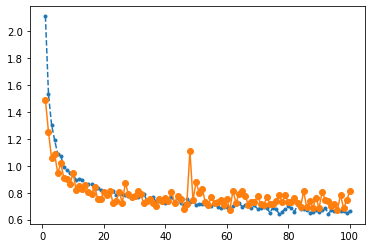

In [207]:
loss = history.history['loss']
epochs = range(1, len(loss) + 1)
val_loss = history.history['val_loss']
plt.plot(epochs, loss, '.--', label='Training loss')
plt.plot(epochs, val_loss, 'o-', label='Validation loss')
plt.show()

In [208]:
y_pred = model2.predict(x_yam_valid)
y_pred = np.argmax(y_pred,axis=1).astype(int)

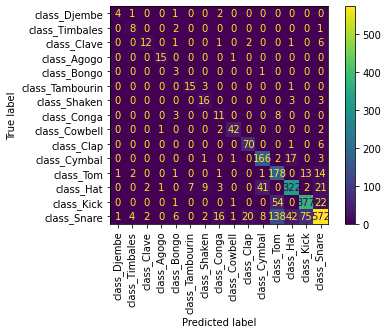

In [209]:
conf_matrix = ConfusionMatrixDisplay(
    confusion_matrix(y_pred, y_valid_index),
    display_labels=classes_cols,
)
conf_matrix.plot(xticks_rotation=90);

In [210]:
print(classification_report(y_pred, y_valid_index, target_names=classes_cols))

                 precision    recall  f1-score   support

   class_Djembe       0.67      0.50      0.57         8
 class_Timbales       0.53      0.73      0.62        11
    class_Clave       0.75      0.52      0.62        23
    class_Agogo       0.88      0.94      0.91        16
    class_Bongo       0.17      0.75      0.27         4
class_Tambourin       0.68      0.79      0.73        19
   class_Shaken       0.52      0.73      0.60        22
    class_Conga       0.31      0.50      0.38        22
  class_Cowbell       0.91      0.89      0.90        47
     class_Clap       0.76      0.91      0.83        77
   class_Cymbal       0.76      0.87      0.82       190
      class_Tom       0.47      0.84      0.60       211
      class_Hat       0.83      0.79      0.81       408
     class_Kick       0.81      0.83      0.82       455
    class_Snare       0.88      0.64      0.74       887

       accuracy                           0.75      2400
      macro avg       0.66   